# Trabajo de aprendizaje activo

Manuel Bajo Buenestado y Kevin Craig Alisauskas

09-04-2019

En este trabajo se comparan distintas de técnicas de Active Learning combinadas con criterios de diversidad, que permiten seleccionar el mejor conjunto de observaciones etiquetadas para un problema de clasificación. 

##### Descripción del problema:

Tenemos un conjunto de datos de imágenes que corresponden a dígitos manuscritos.
El objetivo es obtener el mejor resultado posible minimizando el número de observaciones etiquetadas que usaremos para entrenar un modelo de clasificación seleccionando aquellas muestras que aportan la mayor información y etiquetándolas.

Comenzamos importando las librerías que se van a utilizar en este trabajo:

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from random import randint
from sklearn.utils import resample
from sklearn.metrics.pairwise import rbf_kernel
from scipy.spatial.distance import pdist

A continuación cargamos los datos. Las variables `X_U` y `X_L`son dataframes que contienen las observaciones no etiquetadas y etiquetadas respectivamente. Las variables `y_U` y `y_L` contienen las etiquetas de las observaciones de los dataframes nombrados anteriormente. Las etiquetas de las observaciones de `X_U` no se utilizarán en ningún momento para entrenar los modelos ni para seleccionar las muestras activas, sólo se utilizarán para saber las etiquetas de una observación una vez pasada a la tabla de las muestras etiquetadas `X_L`.

In [35]:
# Unlabeled
U = pd.read_csv("./Datos/semeion_unlabeled.csv", header = None)
X_U = U.iloc[:,1:]
y_U = U.iloc[:,0]

# Test
test = pd.read_csv("./Datos/semeion_test.csv", header = None)
X_test = test.iloc[:,1:]
y_test = test.iloc[:,0]

# Labeled
L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
X_L = L.iloc[:,1:]
y_L = L.iloc[:,0]

El modelo que utilizaremos para entrenar será un clasificador por máquinas de vectores de soporte (SVC). Definimos el modelo en el objeto `model`.

In [36]:
# Definimos la gamma en función de las muestras etiquetadas.
sigma = np.mean(pdist(X_L))
gamma = 1 / (2 * sigma * sigma)

# El modelo sera SVC (un clasificador usando support vector machines)
model = SVC(gamma = gamma, C = 100, probability=True, decision_function_shape = "ovr")

Definimos una función para cada estrategia de Active Learning (AL). Estos criterios de AL son los siguientes:

- MS: margin sampling, o most uncertain
- MCLU: multi-class label uncertainty 
- SSC: significance space construction
- nEQB: normalized entropy query bagging

Las funciones contienen comentarios que explican su funcionamiento.

In [37]:
def MS(model, X_U, already_selected, N):

    distances = []

    # Para todas las distancias a todos los hiperplanos calculamos la media.
    for i in model.decision_function(X_U):
        distances.append(np.linalg.norm(i))
    
    # Ordenamos las muestras por la distancia
    distances = np.array(distances)
    rank_ind = np.argsort(distances)
    
    # Seleccionamos N muestras con la menor distancia
    rank_ind = [i for i in rank_ind if i not in already_selected]
    active_samples = rank_ind[0:N]

    return active_samples, distances[active_samples]

def MCLU(model, X_U, already_selected, N):

    distances = []

    # Definimos las distancias a cada hiperplano
    distances = abs(model.decision_function(X_U))

    # Ordenamos las distancias de menor a mayor
    sort_distances = np.sort(distances, 1)

    # Obtenemos la diferencia entre las distancias de las dos clases más probables (mayores distancias)
    min_margin = sort_distances[:, -1] - sort_distances[:, -2]

    # Ordenamos las muestras no etiquetadas por ese margen mínimo obtenido.
    rank_ind = np.argsort(min_margin)
    rank_ind = [i for i in rank_ind if i not in already_selected]
    active_samples = rank_ind[0:N]

    return active_samples, min_margin[active_samples]

def SSC(model, X_U, already_selected, N):

    distances = []

    # Creamos los conjuntos de train para predecir los vectores soporte.
    X_L_ssc = X_L
    y_L_ssc = np.zeros(y_L.shape)
    y_L_ssc[model.support_] = 1

    # Si solo hay una clase no es necesaria ninguna predicción.
    if len(np.unique(y_L_ssc)) == 1:
        idx = np.random.permutation(X_U.shape[0])
        distances = np.ones(X_U.shape[0])

    # Si no es el caso, creamos el modelo y predecimos cuales de las muestras sin etiquetar serán vectores soporte.
    else:
        model.fit(X_L_ssc, y_L_ssc)
        possible_SVs = model.predict(X_U)
        idx = np.arange(X_U.shape[0])[possible_SVs == 1]
        distances = abs(model.decision_function(X_U))

    # Comprobamos que no estén ya presentes en la muestra seleccionada.
    rank_ind = [i for i in idx if i not in already_selected]

    rank_ind = np.random.permutation(rank_ind)
    active_samples = rank_ind[0:N]

    return active_samples, distances[active_samples]

def nEQB(model, X_U, already_selected, N):

    distances = []

    # Definimos el número de modelos a usar
    n_models = 4
    n_classes = len(np.unique(y_L))

    # Creamos la matriz de predicciones
    n_unlab = X_U.shape[0]
    predMatrix = np.zeros((n_unlab, n_classes))

    # Rellenamos la matriz de predicciones creando muestras bagging con reeemplazamiento.
    for k in range(n_models):
        while True:
            xbag, ybag = resample(X_L, y_L, replace = True)

            # Ensure that we have all classes in the bootstrap replica
            if len(np.unique(ybag)) >= n_classes:
                break
        # Ajustamos el modelo
        model.fit(xbag, ybag)

        # Rellenamos la matriz de predicciones sumando las probabilidades tantas veces como modelos haya.
        predMatrix += model.predict_proba(X_U)

    # Normalize probabilities with the number of used models
    predMatrix /= n_models

    # We already have normalized probabilites, we can compute entropies!
    Hbag = -np.sum(predMatrix * np.log(predMatrix), axis = 1)

    # Select randomly among the ones with maximum entropy.
    idx = np.argsort(Hbag)[::-1]
    distances = Hbag

    # Comprobamos que no estén ya presentes en la muestra seleccionada.
    rank_ind = [i for i in idx if i not in already_selected]
    active_samples = rank_ind[0:N]

    return active_samples, distances[active_samples]

Definimos la función `random_sampling`, que selecciona muestras al azar. Utilizaremos los resultados obtenidos de la clasificación de este muestreo aleatorio para comparar con los resultados obtenidos por los diferentes criterios de AL.

In [38]:
def random_sampling(model, X_U, already_selected, N):

    # Inicializamos las muestras no seleccionadas y las muestras aleatorias que usaremos al final.
    not_selected = []
    random_samples = []

    # Rellenamos las muestras no seleccionadas.
    for i in range(U.shape[0]):

        if [i in already_selected] == [False]:
            not_selected = not_selected + [i]

    # Realizamos una permutación aleatoria de las muestras "unlabeled" que no estuvieran seleccionadas anteriormente y devolvemos las N primeras.
    random_samples = np.random.permutation(not_selected)[0:N].tolist()

    return random_samples

Definimos una función para cada criterios de diversidad que utilizaremos para asegurar que las muestras activas contienen la mínima información redundante. Estos criterios son:

- MAO (most ambiguous and orthogonal)
- MAO lambda
- Diversidad por clustering

Las funciones contienen comentarios que explican su funcionamiento.

In [39]:
def MAO(X_U, distances, active_samples, n):

    active = np.array(active_samples)
    labeled = np.array(X_L)

    # Usamos un kernel gaussiano para calcular distancias entre las 30 muestras preseleccionadas
    K = rbf_kernel(X_U, gamma = gamma)

    # Creamos un vector vacío para las posiciones de X_U finales a seleccionar como activas.
    mao_samples = np.zeros(n, dtype=type(active[0]))

    # Rellenamos el vector.
    for i in range(n):

        # La primera muestra se toma como activa automáticamente.
        mao_samples[i] = active[0]
        active = active[1:]

        # Obtenemos las distancias de las muestras seleccionadas con las preseleccionadas
        Kdist = K[mao_samples[0:i+1], :][:, active]

        # Distancia mínima de cada muestra preseleccionada con alguna de las seleccionadas.
        Kdist = Kdist.min(axis = 0)

        # Remuestreamos ordenando por distancias.
        active = active[Kdist.argsort(axis = 0)]

    mao_samples = mao_samples.tolist()

    return mao_samples

def MAO_lam(X_U, distances, active_samples, n):


    # MAO lambda: trade-off between uncertainty and diversity
    lam = 0.6

    active = np.array(active_samples)

    # Usamos un kernel gaussiano para calcular distancias entre las 30 muestras preseleccionadas
    K = rbf_kernel(X_U, gamma = gamma)

    # Creamos un vector vacío para las posiciones de X_U finales a seleccionar como activas.
    mao_samples = np.zeros(n, dtype=type(active[0]))

    # Rellenamos el vector.
    for i in range(n):

        # La primera muestra se toma como activa automáticamente.
        mao_samples[i] = active[0]
        active = active[1:]
        distances = distances[1:]

        # Obtenemos las distancias de las muestras seleccionadas con las preseleccionadas
        Kdist = K[mao_samples[0:i+1], :][:, active]

        # Distancia mínima de cada muestra preseleccionada con alguna de las seleccionadas.
        Kdist = Kdist.min(axis = 0)

        # Trade-off between MS and Diversity
        heuristic = distances * lam + Kdist * (1 - lam)
        active = active[heuristic.argsort()]  # axis=0
        distances = distances[heuristic.argsort()]

    mao_samples = mao_samples.tolist()

    return mao_samples


def diversity_clustering(X_U, distances, active_samples, n):
    
    # Se define un modelo de clustering y agrupamos las muestras en n clusters
    kmeans = KMeans(n_clusters=n).fit(X_U.iloc[active_samples])
    labels = kmeans.labels_
    diversity_samples = []
    
    # Se escoge una muestra de cada cluster, 
    #teniendo en cuenta el orden en el que han sido elegidas por el criterio de AL
    for i in range(n):
        for j in range(len(labels)):
            if (labels[j] == i) :
                diversity_samples = diversity_samples + [active_samples[j]]
                break

    return diversity_samples

Comenzamos entrenando el modelo con un conjunto de muestras etiquetadas elegidas al azar mediante la función `random_sampling`. Evaluamos el modelo 30 veces, cogiendo al azar cada vez 10 muestras etiquetadas adicionales. Utilizaremos los resultados para comparar con los resultados obtenidos mediante los criterios de AL. 

Realizaremos este experimento 100 veces y se calculará el resultado medio para garantizar unos resultados estadísticamente significativos. El resultado de cada experimento individual depende de manera significativa del azar.

In [40]:
### comenzamos con random sampling, que usaremos para comparar el resto de metodos
M = 30 # numero iteraciones. Se acaba con M*10 muestras etiquetadas
N = 100 #numero de veces que se repite el experimento

res = np.empty((N, M))

for j in range(N):
    
    random_accuracy = []
    already_selected = []
    
    # Cargamos de nuevo el conjunto Labeled.
    L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
    X_L = L.iloc[:, 1:]
    y_L = L.iloc[:, 0]
    
    for i in range(M):

        # Ajustamos el modelo con los datos etiquetados de train
        model.fit(X_L, y_L)

        # Predecimos para los datos test
        y_pred = model.predict(X_test)

        # Evaluamos el acierto.
        random_accuracy = random_accuracy + [accuracy_score(y_pred, y_test)]

        # Seleccionamos las nuevas muestras activas con la función random_sampling de forma aleatoria.
        active_samples = random_sampling(model, X_U, already_selected, 10)

        # Guardamos las muestras nuevas activas como seleccionadas.
        already_selected = already_selected + active_samples

        # Añadimos las nuevas muestras labeled al conjunto original.
        L = L.append(U.iloc[active_samples, :])

        X_L = L.iloc[:,1:]
        y_L = L.iloc[:,0]
    
    
    res[j, :] = np.array(random_accuracy)
    random_accuracy = list(res.mean(axis=0))

Entrenamos la SVC seleccionando las muestras etiquetadas mediante todas las combinaciones posibles de criterios de AL y de diversidad. Cada combinación se evaluará 30 veces, eligiendo cada vez 10 muestras activas adicionales.

De nuevo, realizaremos este experimento 100 veces para cada combinación y se calculará el resultado medio para garantizar unos resultados estadísticamente significativos. El resultado de cada experimento individual depende de manera significativa del azar.

In [41]:
# Resto de metodos de AC + criterio_diversidad

#M = 30  numero iteraciones. Se acaba con M*n_diver muestras etiquetadas
#N = 2 numero de veces que se repite el experimento
n_al = 30 # numero de muestras activa que se seleccionan en cada iteracion
n_diver = 10 # numero de muestras que se selecionan de las muestras activas a traves de un criterio de diversidad para cada iteracion
sampling_methods = [MS, MCLU, SSC, nEQB]
diversity_methods = [diversity_clustering, MAO, MAO_lam]
acc = np.empty((len(sampling_methods)*len(diversity_methods), M))
idx = 0
res = np.empty((N, M))

for j in range(len(sampling_methods)):
    for k in range(len(diversity_methods)):
        for idy in range(N):

            # Definimos un vector de aciertos y otro de las muestras ya escogidas para cada combinación de métodos.
            accuracy = []
            already_selected = []

            # Cargamos de nuevo el conjunto Labeled.
            L = pd.read_csv("./Datos/semeion_labeled.csv", header = None)
            X_L = L.iloc[:, 1:]
            y_L = L.iloc[:, 0]

            # Realizamos las M iteraciones para cada combinación de métodos..
            for i in range(M):

                # Ajustamos el modelo.
                model.fit(X_L, y_L)

                # Predecimos con test.
                y_pred = model.predict(X_test)

                # Obtenemos y almacenamos el acierto para cada combinación.
                accuracy = accuracy + [accuracy_score(y_pred, y_test)]

                # Obtenemos las muestras activas previas a partir de un determinado método de selección.
                active_samples, distances = sampling_methods[j](model, X_U, already_selected, n_al)

                # Obtenemos las muestras finales a partir de un determinado método de diversidad.
                active_samples = diversity_methods[k](X_U, distances, active_samples, n_diver)

                # Almacenamos esas muestras activas finales.
                already_selected = already_selected + active_samples

                # Añadimos esas muestras a nuestro conjunto de muestras etiquetadas.
                L = L.append(U.iloc[active_samples, :])
                X_L = L.iloc[:, 1:]
                y_L = L.iloc[:, 0]
                
            res[idy, :] = np.array(accuracy)
            accuracy = list(res.mean(axis=0))

        acc[idx, :] = np.array(accuracy)
        idx = idx + 1

Se presentan la precisión de la SVC entrenada mediante muestras etiquetadas seleccionadas a través de cada combinación de posible de criterios de AL y de diversidad. Cada gráfico contiene en líneas discontínuas la precisión del modelo de clasificación para el caso en el que las muestras etiquetadas son elegidas al azar.

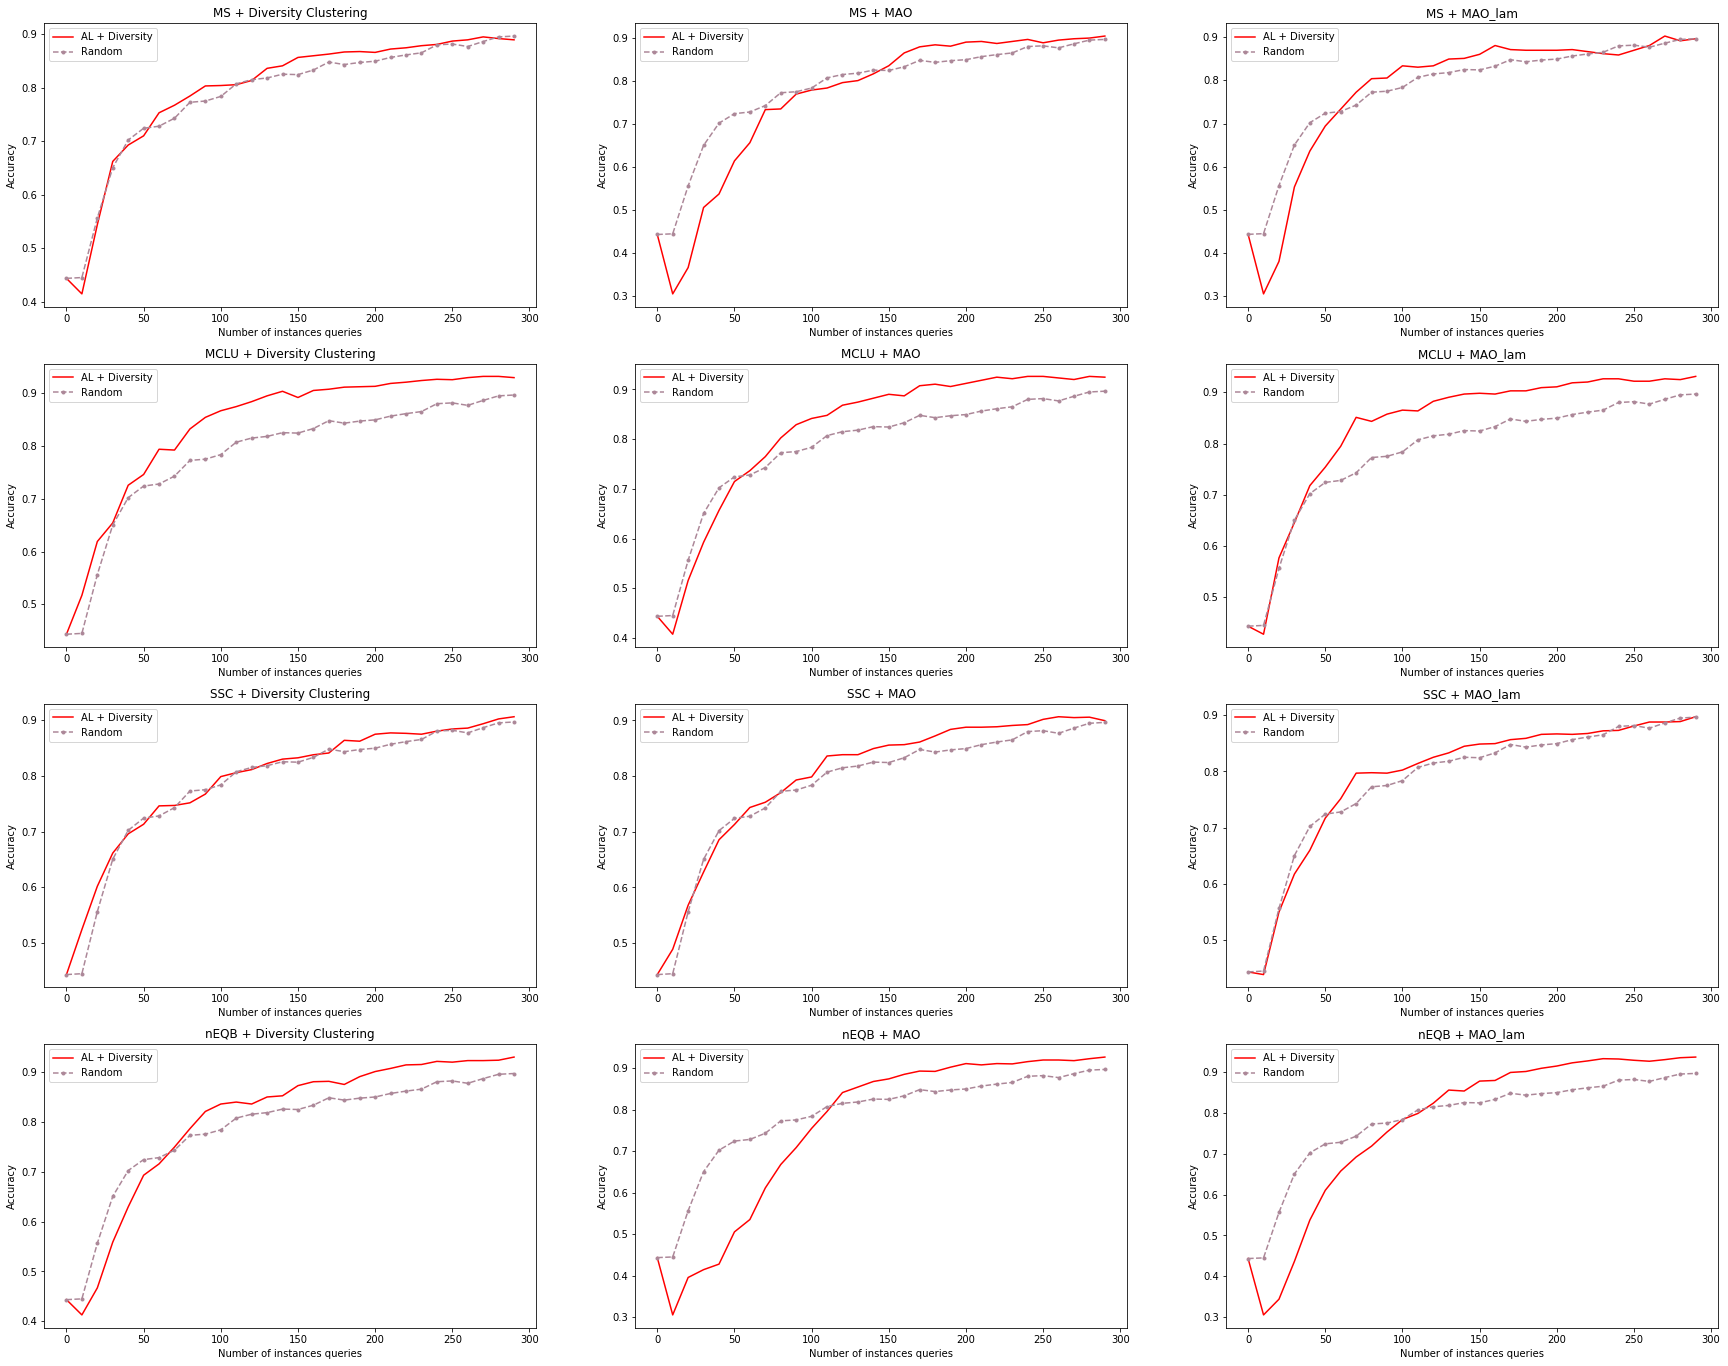

In [42]:
# Graficas 
al = ["MS"]*len(diversity_methods) + ["MCLU"]*len(diversity_methods) + ["SSC"]*len(diversity_methods) + ["nEQB"]*len(diversity_methods)
diversity = ["Diversity Clustering", "MAO", "MAO_lam"]*len(sampling_methods)
x = np.arange(M*n_diver, step = 10)

fig = plt.figure(figsize= (30 , 24))

for i in range(acc.shape[0]):
    fig.add_subplot(4, 3, i + 1)
    plt.plot(x, acc[i,:], "r")
    plt.plot(x, random_accuracy, ".--", color = "#AC8798")
    plt.title(al[i] + " + " + diversity[i])
    plt.legend(("AL + Diversity","Random"))
    plt.ylabel("Accuracy")
    plt.xlabel("Number of instances queries")
    plt.show

# plt.savefig('resultados.png')

### Conclusión
